In [105]:
import IPython.display as ipd
import wave
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

Opened audio file 'data/03-01-05-01-01-01-01_A1.wav':
  Channels: 1
  Sample width: 2
  Frame rate: 48000
  Frames: 185786
  Compression type: NONE
  Compression name: not compressed


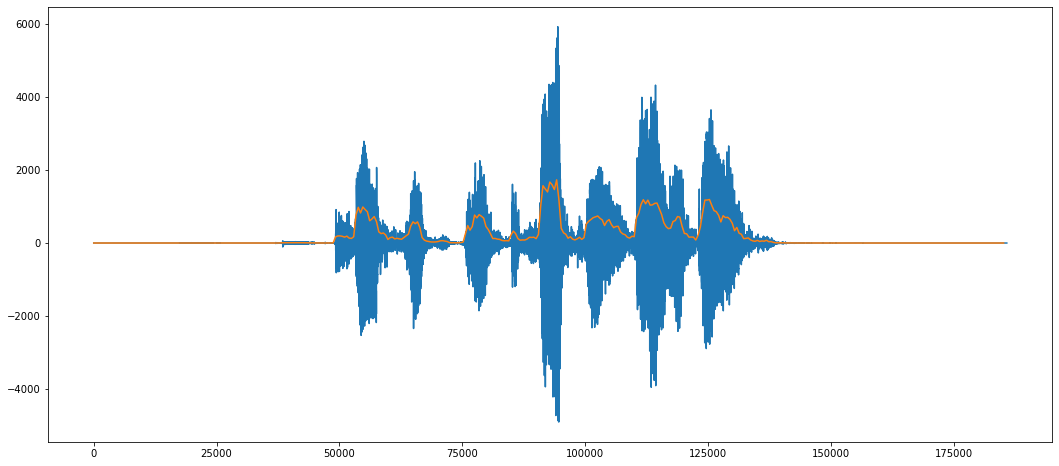

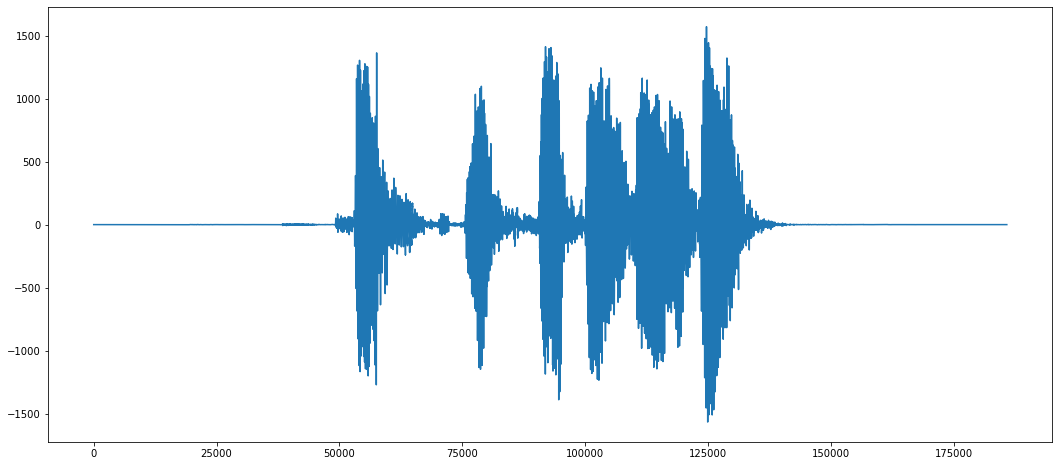

In [121]:
filename = "data/03-01-05-01-01-01-01_A1.wav"

types = {
    1: np.int8,
    2: np.int16,
    4: np.int32
}

audiofile = wave.open(filename, "rb")

print("Opened audio file '{}':".format(filename))
print("  Channels:", audiofile.getnchannels())
print("  Sample width:", audiofile.getsampwidth())
print("  Frame rate:", audiofile.getframerate())
print("  Frames:", audiofile.getnframes())
print("  Compression type:", audiofile.getcomptype())
print("  Compression name:", audiofile.getcompname())

signal = np.frombuffer(audiofile.readframes(audiofile.getnframes()), types[audiofile.getsampwidth()])
signal_length = len(signal)

# task 1
envelope = []
envelope_length = 400
frame_length = signal_length // envelope_length

for j in range(envelope_length):
    s = 0.0
    for k in range(frame_length * j, frame_length * (j + 1)):
        s += np.abs(signal[k])
    envelope.append(s / frame_length)

plt.figure(figsize=(18, 8))
plt.plot(signal)
plt.plot([frame_length * i for i in range(envelope_length)], envelope)
plt.show()

# task 2
p = 1
sf = 500
wn = 2 * sf / audiofile.getframerate()
b, a = sig.butter(p, wn, "lowpass")
changed_signal = sig.filtfilt(b, a, signal)

plt.figure(figsize=(18, 8))
plt.plot(changed_signal)
plt.show()

# task 3
    
ipd.Audio(changed_signal, rate=audiofile.getframerate())